In [3]:
!pip install seaborn pandas matplotlib skunk svglib

In [38]:
import symd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pickle
import pandas as pd
import skunk
import svglib
import seaborn as sns

In [39]:
base_colors = ["f94144","f3722c","f8961e","f9844a","f9c74f","90be6d","43aa8b","4d908e","577590","277da1"]    
colors = ['#' + c for c in base_colors]
sns.set_style("white")
sns.set_style("ticks")
sns.set(rc={'axes.facecolor':'#f5f4e9', 
            'grid.color' : '#AAAAAA', 
            'axes.edgecolor':'#333333', 
            'figure.facecolor':'#FFFFFF', 
            'axes.grid': False,
            'axes.prop_cycle':   plt.cycler('color', plt.cm.Dark2.colors),
            'font.family': 'monospace'
           })
titles = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']
print(symd.__version__)

0.2.1


## Atlas

In [40]:
def scale(x, ib):
    s = np.apply_along_axis(lambda xi: ib @ xi, 1, x)
    return np.fmod(s, 1.0)

def compute_symm(positions, gnum, cell, ndim, n):
    group = symd.groups.load_group(gnum, ndim)
    cell = np.array(cell).reshape(ndim,ndim)
    ib = np.linalg.inv(cell)
    s = scale(positions[:,:ndim], ib)    
    members = [symd.groups.str2mat(e) for e in group['genpos']]
    folded_positions = np.zeros_like(s)
    for i in range(n):
        folded_positions[i,:] = s[i,:]
        for j in range(1, len(members)):
            k = j * n + i
            im = np.linalg.inv(members[j])
            w = im[:ndim, :ndim]            
            folded_positions[i,:] += w @ s[k] + im[ndim, :ndim]
        folded_positions[i, :] /= len(members)
        for j in range(1, len(members)):
            k = j * n + i
            w = members[j][:ndim, :ndim]            
            folded_positions[k] = w @ folded_positions[i] + members[j][ndim, :ndim]    
    return np.mean((s[:k] - folded_positions[:k])**2)
def rmsd(p1, p2):
    return np.mean((p1 - p2)**2, axis=(1,2))

In [71]:
def crystal(n, group, w=None, retries=2, steps=10**6, steps2=5*10**3, ndims=2, starting_density=0.2):
    # adjust for group size
    m = len(symd.groups.load_group(group, ndims)['genpos'])
    n = max(2, n // m)
    if w is not None:
        n += sum(w)
        name = f'{group}-{n}-{sum(w)}'
    else:
        name = f'{group}-{n}'
    print('Simulating', n, 'particles:', name)
    # break out the try/except because we will accept failed NPT (because it jams so hard)
    for i in range(retries):
        cell = symd.groups.get_cell(starting_density, group, 2, n, w)
        # NPT
        md = symd.Symd(nparticles=n, cell=cell, ndims=ndims, images=2, force='lj', wyckoffs=w,
          group=group, steps=steps, exeDir=f'crystal-{name}', pressure=0.25, temperature=0.1, start_temperature=0.5)
        try:        
            md.remove_overlap()
        except RuntimeError as e:
            continue
        md.log_positions()
        try:
            md.run()
        except RuntimeError as e:
            d = md.number_density()
            if d < 0.:
                print('Not dense enough, retrying', d)
                continue

        # NVT
        md.runParams['start_temperature'] = 0.0
        md.runParams['temperature'] = 1e-5
        md.runParams['box_update_period'] = 0
        md.runParams['steps'] = steps // 4
        md.log_positions(filename='equil.xyz')
        try:
            md.run()
        except RuntimeError as e:
            continue
        config = md.positions[-1]

        # Stability
        fp = np.loadtxt(md.runParams['final_positions'])
        # changing group, so need to read projected cell
        cell = md.read_cell(bravais=True)
        m = fp.shape[0]
        md2 = symd.Symd(nparticles=m, cell=cell, ndims=2, images=2, force='lj', wyckoffs=None,
          group=1, steps=steps2, exeDir=f'melt-{name}', temperature=None, start_temperature=0.0)
        # run once to get melting traj
        # then again for longer with longer period
        md2.log_positions(period=10)
        md2.runParams['start_positions'] = md.runParams['final_positions']            
        try:
            md2.run()
        except RuntimeError as e:
            continue
        traj = md2.positions
        csm = rmsd(md2.positions[:,:m], md2.positions[0,:m])
        #csm = []
        #for i in range(md2.positions.shape[0]):
        #    csm.append(compute_symm(md2.positions[i], group, md2.read_cell(), ndims, n))
        return config, md2.positions[-1], md2.number_density(), csm, traj, np.arange(0,steps2,10) * md2.runParams['time_step']
    return None

In [76]:
config, config2, nd, csm, traj, time = crystal(16, 5)

Simulating 4 particles: 5-4


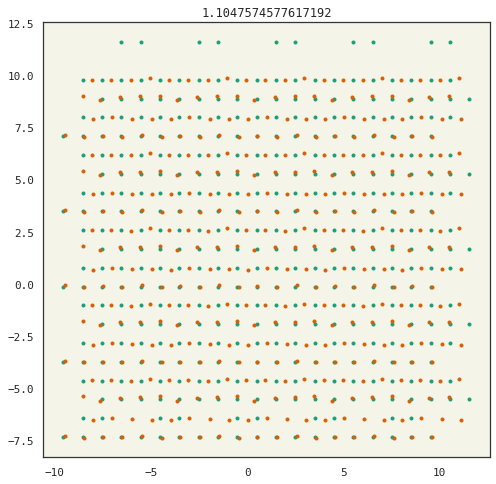

In [77]:
plt.figure(figsize=(8, 8))
plt.title(f'{nd}')
plt.plot(config[:,0], config[:,1], '.')
plt.plot(config2[:,0], config2[:,1], '.')

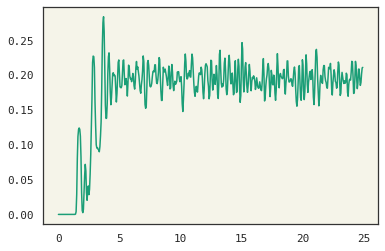

In [78]:
plt.plot(time, csm)

In [ ]:
#are you sure you want to run this?

from multiprocessing import Pool

cdf = None
results = []
trajs = {}

with Pool(6) as pool:
    for N in [8,16,32,128]:
        for i,t in enumerate(titles):
            W = len(symd.groups.load_group(i+1, 2)['specpos'])    
            for j in range(1 + W):
                wycks = None if j == 0 else [1] * j
                name = f'{t}-w{j}-n{N}'
                job = pool.apply_async(crystal, (N, i+1, wycks))
                #job = crystal(N, i+1, wycks)
                results.append((t, name, N, j, job))
                
    for r in results:        
        t, name, N, j, ar = r
        print('Getting result for ', name)
        res = ar.get()
        #res = ar
        if res is None:
            continue
        config, config2, nd, csm, traj, time = res
        T = len(csm)
        
        df2 = pd.DataFrame({'Group':[t] * T, 'Traj': [name] * T, 'rho': [nd] * T,
                            'N':[N] * T, 'Wyckoffs':[str(j)] * T, 'RMSD':csm, 'Time':time})
        if cdf is None:
            cdf = df2
        else:
            cdf = pd.concat((cdf, df2))
        trajs[name] = traj
        
cdf.reset_index(inplace=True)
cdf.to_pickle('atlas2d.pkl.gz')
with open('atlas2d.traj.pkl', 'wb') as f:
    pickle.dump(trajs, f, pickle.HIGHEST_PROTOCOL)

SimulatingSimulatingSimulatingSimulatingSimulatingSimulating      874658     particles: particles:particles:particles:particles: particles:    1-8 2-7-32-6-22-42-5-12-8-4





Getting result for  p1-w0-n8
Simulating 4 particles: 3-4
Simulating 5 particles: 3-5-1
{"steps": 1000, "n_particles": 5, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-3-5-1/group-3.dat", "cell_log_file": "crystal-3-5-1/cell_log_file.dat", "print_period": 10000.0, "cell": [6.70821, 0.0, 0.0, 6.70821], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-3-5-1/group-3.dat", "group": "crystal-3-5-1/group-3.json", "wyckoffs": [{"group": "crystal-3-5-1/group-3-00.json", "n_particles": 1}]}
Info: You are running version cf9

In [8]:
cdf = pd.read_pickle('atlas2d.pkl.gz')
with open('atlas2d.traj.pkl', 'rb') as f:
    trajs = pickle.load(f)

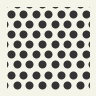

In [9]:
def plot_config(pos, figsize=(1.5,1.5), color='#333333'):
    N, D = pos.shape    
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(pos[:,0], pos[:,1], color=color, marker='o', markersize=8, markeredgewidth=0.0, linestyle='None')
    ax.set_facecolor('#f5f4e9')
    fig.patch.set_facecolor('#f5f4e9')
    ax.axis('off')
    # want about 64 points
    #q = max(0.05, min(0.5, 64 / N))
    #xlim = np.quantile(pos[:,0], [0.5 - q, 0.5 + q])
    #ylim = np.quantile(pos[:,1], [0.5 - q, 0.5 + q])    
    xlim = (-3,3)
    ylim = (-3,3)
    ax.set_aspect('equal') 
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    plt.tight_layout()
    return skunk.pltsvg(fig=fig)
skunk.display(plot_config(trajs['pg-w0-n16'][0]))

/tmp/ipykernel_3691/852829583.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


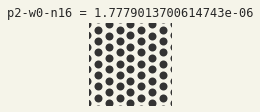

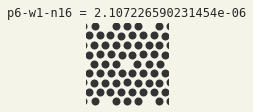

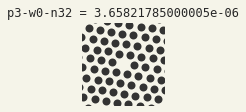

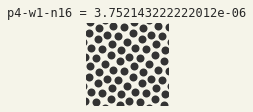

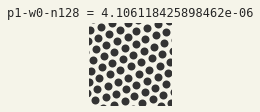

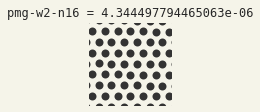

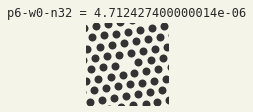

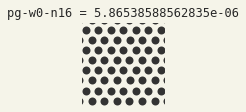

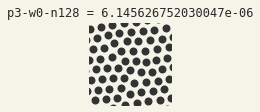

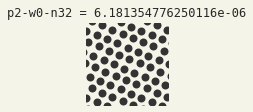

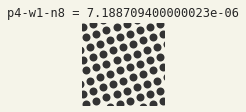

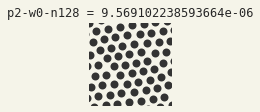

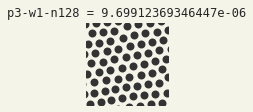

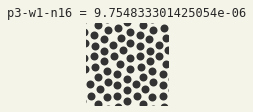

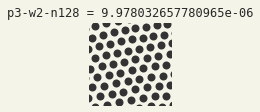

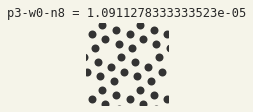

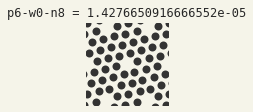

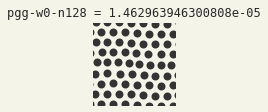

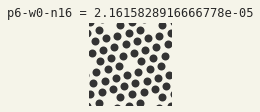

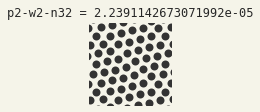

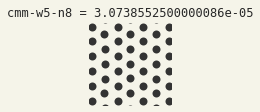

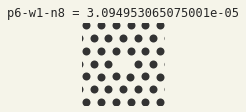

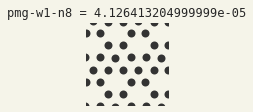

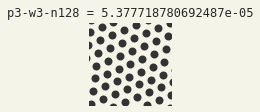

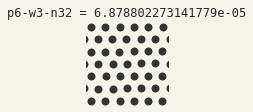

In [10]:
top = cdf[cdf.Time == cdf.Time.max()].sort_values(by=['RMSD'])[:25]
for r,t in zip(top.RMSD.values, top.Traj.values):
    plot_config(trajs[t][0])
    plt.title(f'{t} = {r}')

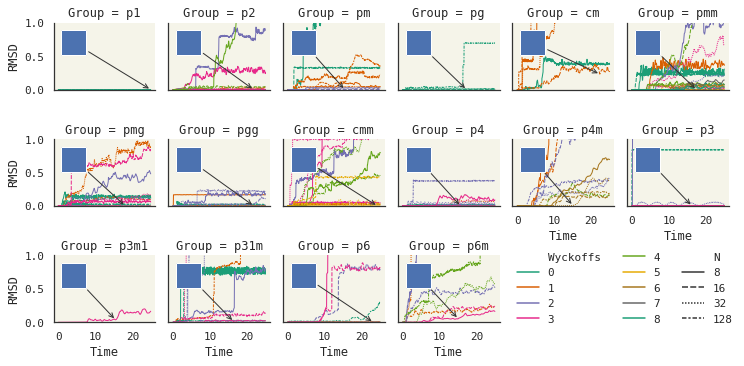

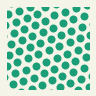

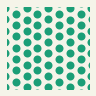

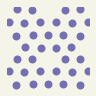

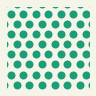

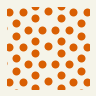

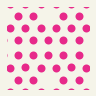

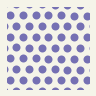

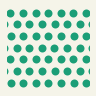

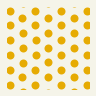

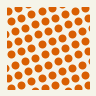

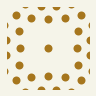

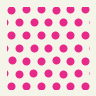

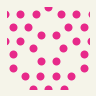

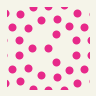

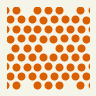

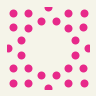

In [62]:
replaces = []
def annotate_config(rmsd, traj, time, wyckoffs, color):
    late_rmsd = rmsd.where(time > 15)
    idx = late_rmsd.argmin()
    label = traj.iloc[idx]
    w = wyckoffs.iloc[idx]
    replaces.append((label, f'C{w}'))
    x = time.iloc[idx]
    y = rmsd.iloc[idx]
    ax = plt.gca()
    box = skunk.Box(25, 25, label)    
    ab = mpl.offsetbox.AnnotationBbox(box, (x, y),
                        pad=0,
                        bboxprops=dict(edgecolor='#333', linewidth=1),
                        xybox=(0.2, 0.7),
                        xycoords='data',
                        boxcoords='axes fraction',
                        arrowprops=dict(arrowstyle="->",color='#333'))

    ax.add_artist(ab)

g = sns.relplot(data=cdf.query('rho > 0.5'), x='Time', y='RMSD', 
        kind='line', hue='Wyckoffs', col='Group', col_wrap=6,
        aspect=1, linewidth=1, style='N', height=1.75, palette='Dark2',
               hue_order=[str(i) for i in range(9)])
plt.ylim(0,1)
sns.move_legend(g, "lower right", bbox_to_anchor=(0.9,0.1), ncol=3)
g.map(annotate_config, 'RMSD', 'Traj', 'Time', 'Wyckoffs').set_axis_labels("Time", "RMSD")


main_svg = skunk.pltsvg()
svg = skunk.insert({l: plot_config(trajs[l][0], color=c) for l,c in replaces}, svg=main_svg)
skunk.display(svg)
with open('atlas.svg', 'w') as f:
    f.write(svg)

In [14]:
cdf.query('rho > 0.5').Traj.unique().shape

(169,)

## Movie

In [30]:
# make a movie
import moviepy.editor as editor
from moviepy.video.io.bindings import mplfig_to_npimage


def plot_traj(traj, title='@_172135352171_', color='#333333', fps=60):
    T, N, D = traj.shape    
    fps = fps
    duration = T / fps
    dpi = 90
    fig, ax = plt.subplots(figsize=(1200 / dpi, 800 / dpi), dpi=dpi)    
    points = ax.plot(traj[0,:,0], traj[0,:,1], color=color, marker='o', markersize=15, markeredgewidth=1.0, linestyle='None', alpha=1.0)[0]
    ax.set_facecolor('#f5f4e9')
    fig.patch.set_facecolor('#f5f4e9')
    title = ax.set_title(title, fontsize=32, color='#333333',fontname='monospace')
    ax.axis('off')
    #xlim = np.quantile(traj[:,:,0], [0.3, 0.8])
    #ylim = np.quantile(traj[:,:,1], [0.3, 0.8])
    xlim = (-6,6)
    ylim = (-6,6)
    ax.set_aspect('equal')    
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    #plt.tight_layout()
    def make_frame(t):
        i = int(t  * fps)
        i = min(i, T-1)
        points.set_data(traj[i,:,0], traj[i,:,1])    
        return mplfig_to_npimage(fig)

    return editor.VideoClip(make_frame, duration=duration)
def write_video(clips, output, fps=60, transition=0.25):
    composite = editor.concatenate(clips[:1] + [c.crossfadein(transition) for c in clips[1:]], 
                                   padding=-transition, method='compose')   
    composite.write_videofile(output, fps=fps, preset='slower', ffmpeg_params=['-tune', 'animation'])

Moviepy - Building video p3.mp4.
Moviepy - Writing video p3.mp4



Moviepy - Done !
Moviepy - video ready p3.mp4


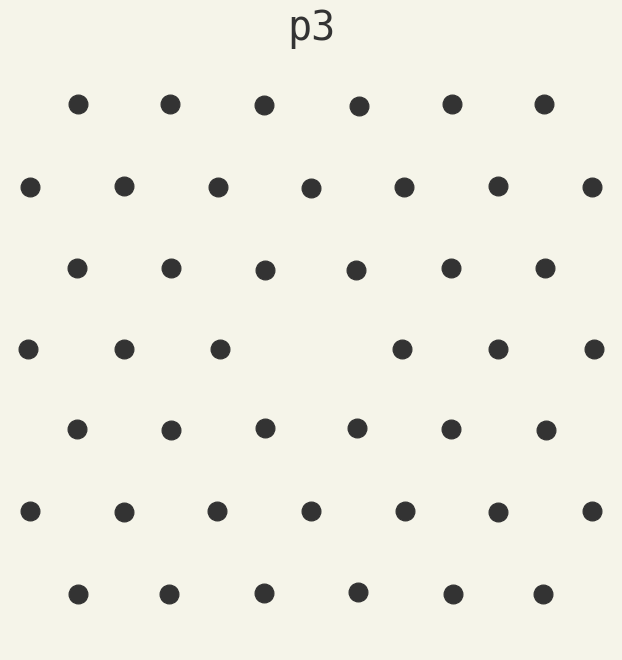

In [28]:
c = plot_traj(traj, title='p3')
write_video([c], f'p3.mp4')

t:   2%|███▊                                                                                                                                                                                                                                | 69/4125 [13:45<01:58, 34.34it/s, now=None]

Moviepy - Building video top.mp4.
Moviepy - Writing video top.mp4




t:   5%|███████████▏                                                                                                                                                                                                                       | 203/4125 [00:07<03:11, 20.47it/s, now=None]


t:   9%|████████████████████                                                                                                                                                                                                               | 364/4125 [00:15<03:08, 19.97it/s, now=None]


t:  13%|████████████████████████████▊                                                                                                                                                                                                      | 523/4125 [00:23<03:10, 18.94it/s, now=None]


t:  17%|█████████████████████████████████████▋                                                                                                                                                                                             | 685/4125 [00:31<03:13, 17.82it/s, now=None]


t:  21%|██████████████████████████████████████████████▌                                                                                                                                                                                    | 847/4125 [00:40<03:22, 16.19it/s, now=None]


t:  24%|███████████████████████████████████████████████████████▎                                                                                                                                                                          | 1009/4125 [00:48<03:32, 14.66it/s, now=None]


t:  28%|████████████████████████████████████████████████████████████████▏                                                                                                                                                                 | 1171/4125 [00:56<03:57, 12.42it/s, now=None]


t:  32%|█████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 1334/4125 [01:04<03:42, 12.55it/s, now=None]


t:  36%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                                                | 1497/4125 [01:12<03:26, 12.70it/s, now=None]


t:  40%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                       | 1660/4125 [01:21<03:04, 13.33it/s, now=None]


t:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 1819/4125 [01:29<02:21, 16.25it/s, now=None]


t:  48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 1973/4125 [01:37<01:42, 21.09it/s, now=None]


t:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 2134/4125 [01:45<01:32, 21.50it/s, now=None]


t:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 2276/4125 [01:53<01:36, 19.21it/s, now=None]


t:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 2401/4125 [02:00<01:28, 19.46it/s, now=None]


t:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 2548/4125 [02:08<01:15, 20.78it/s, now=None]


t:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 2708/4125 [02:16<01:07, 21.03it/s, now=None]


t:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 2868/4125 [02:25<00:59, 20.98it/s, now=None]


t:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 3028/4125 [02:33<00:51, 21.18it/s, now=None]


t:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 3188/4125 [02:41<00:44, 20.84it/s, now=None]


t:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 3343/4125 [02:49<00:40, 19.51it/s, now=None]


t:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 3499/4125 [02:57<00:31, 19.92it/s, now=None]


t:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 3661/4125 [03:06<00:23, 19.54it/s, now=None]


t:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 3821/4125 [03:14<00:18, 16.65it/s, now=None]


t:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 3982/4125 [03:22<00:09, 15.85it/s, now=None]


t:   2%|███▊                                                                                                                                                                                                                                | 69/4125 [17:15<01:58, 34.34it/s, now=None]

Moviepy - Done !
Moviepy - video ready top.mp4


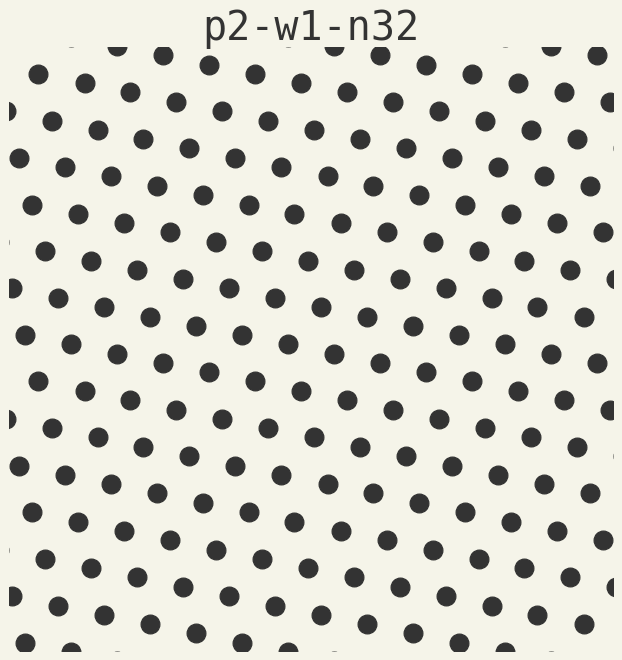

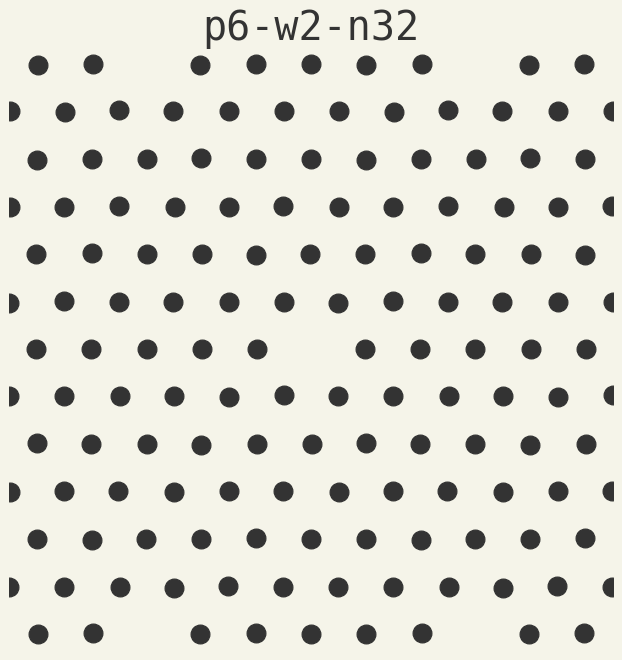

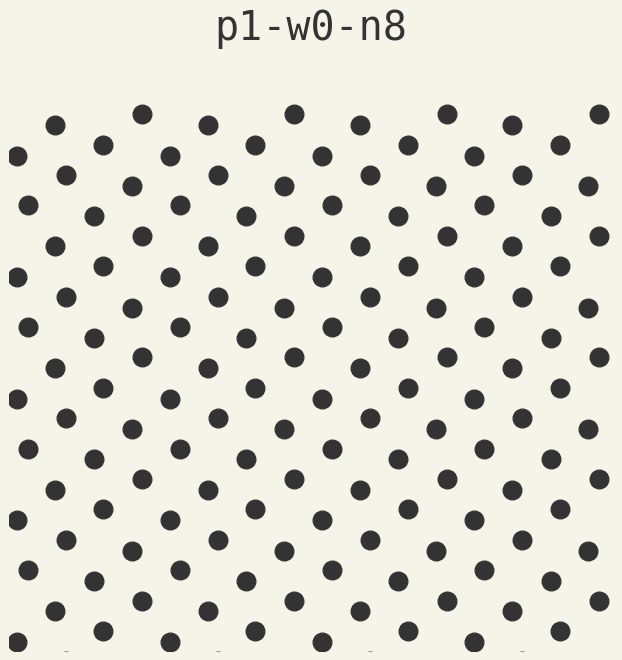

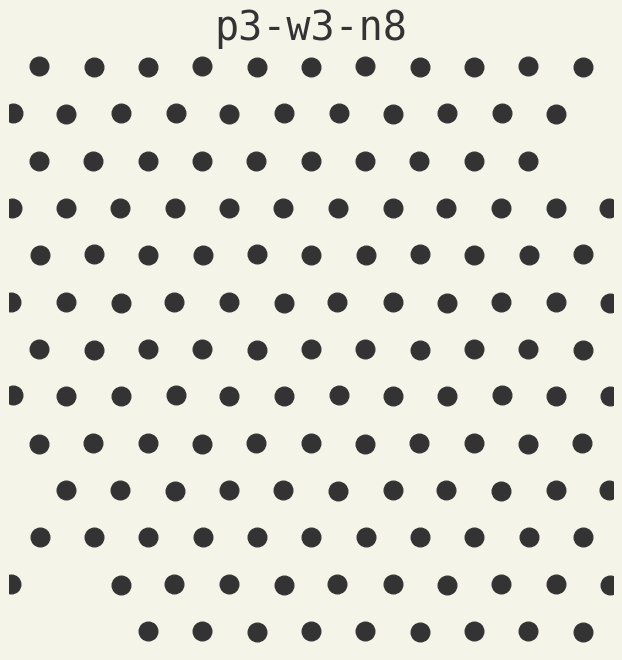

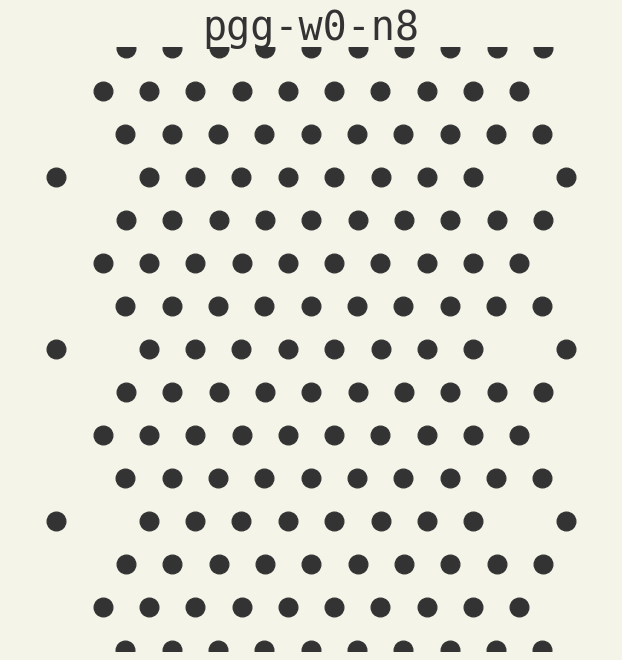

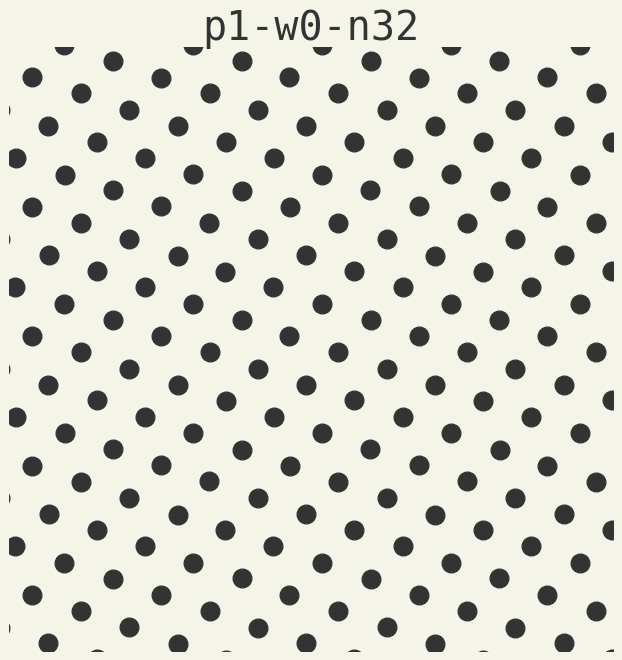

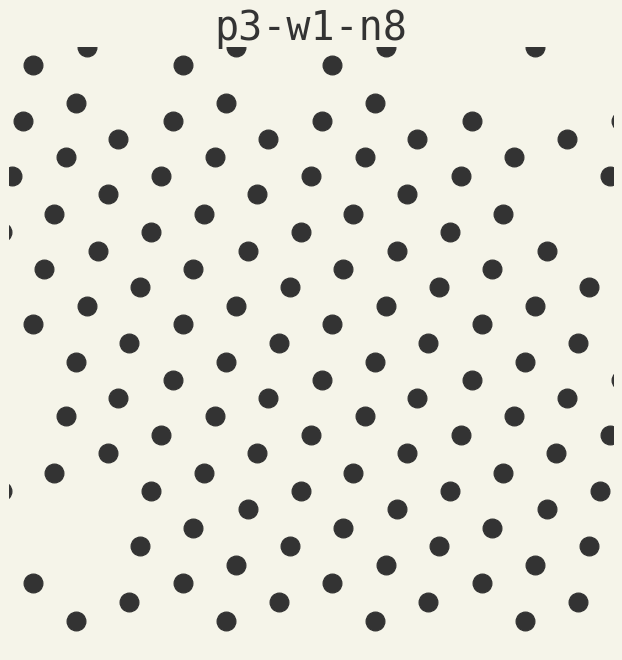

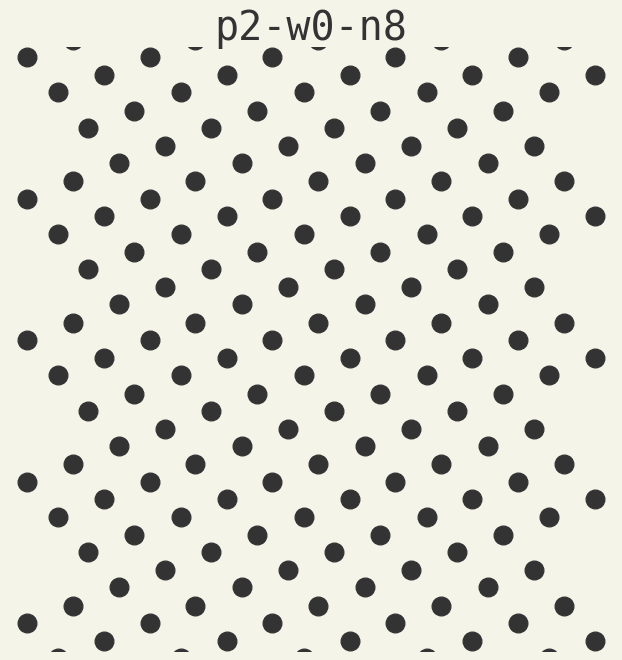

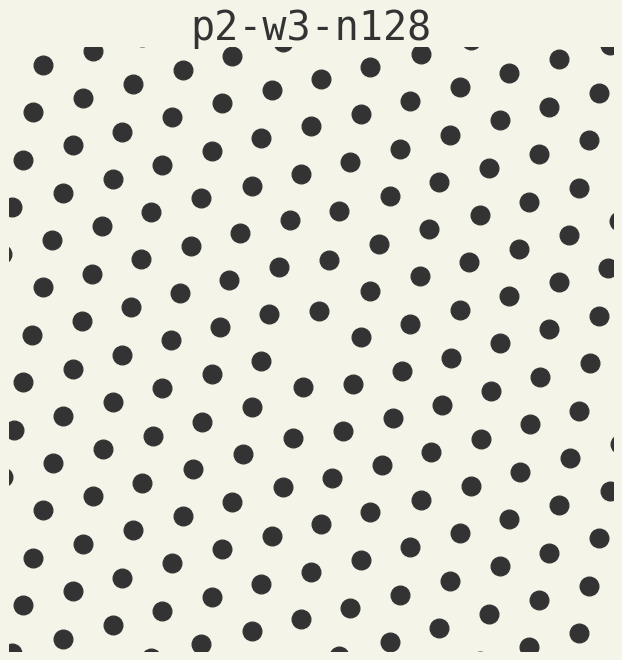

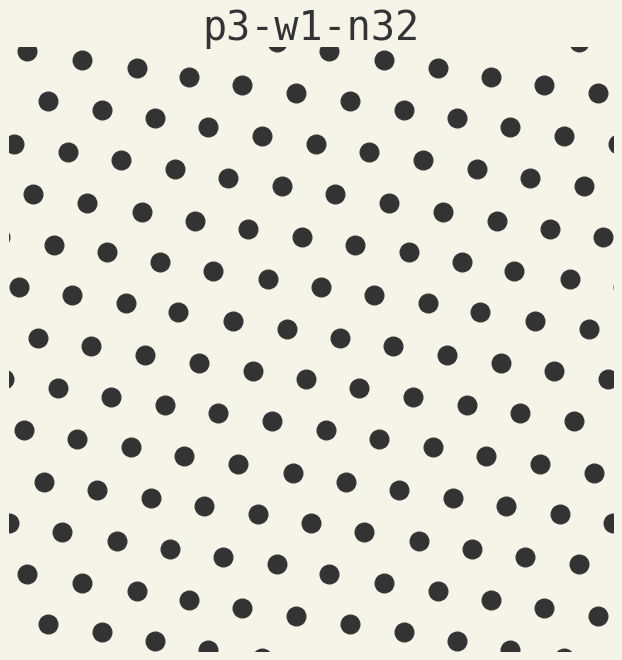

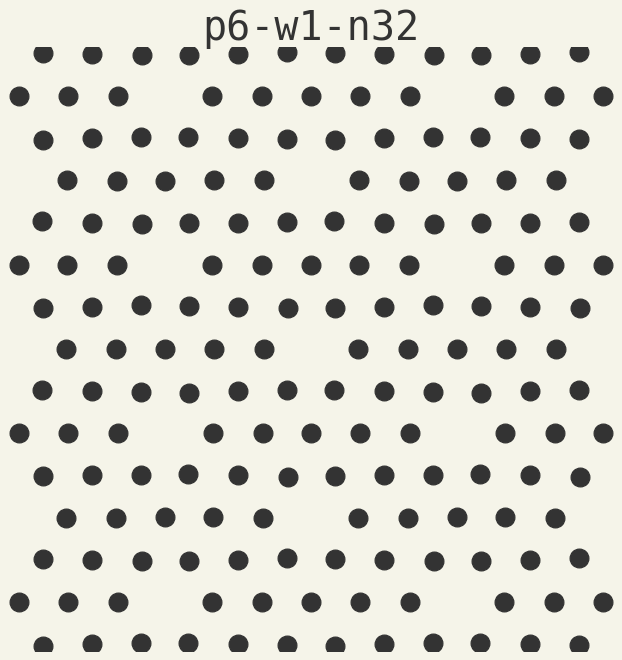

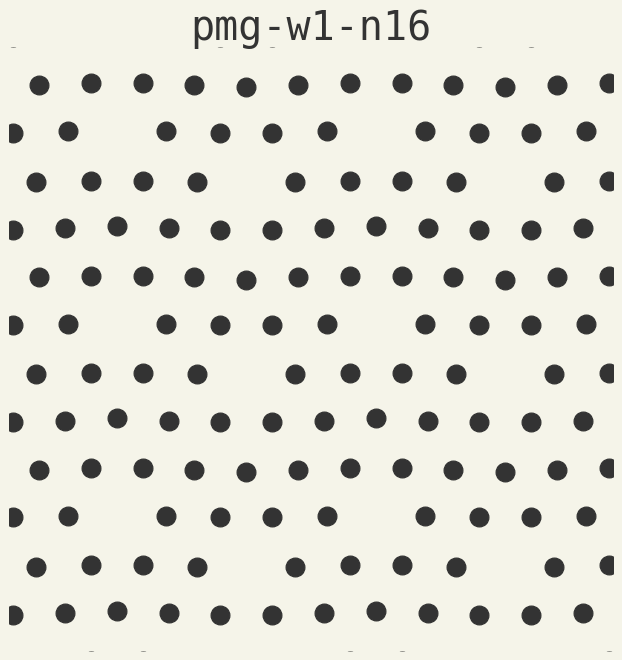

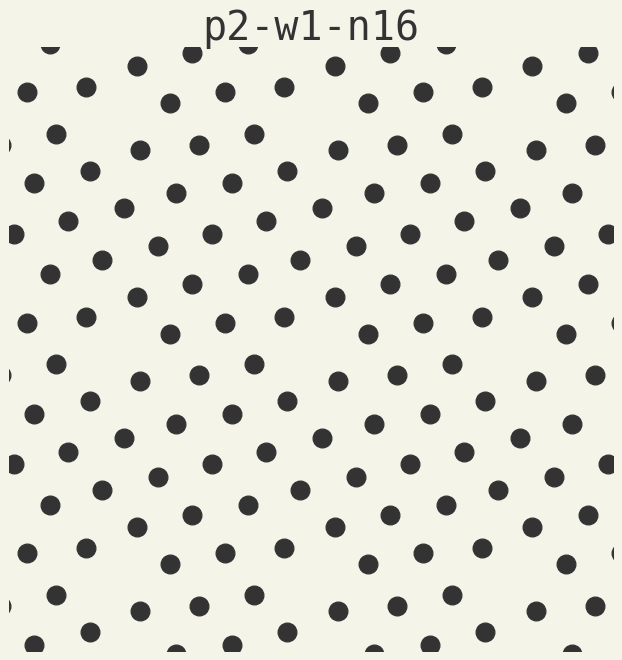

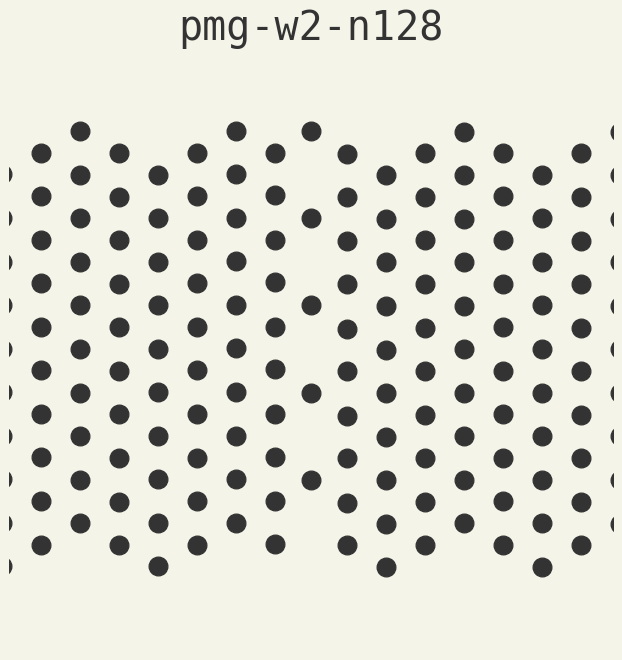

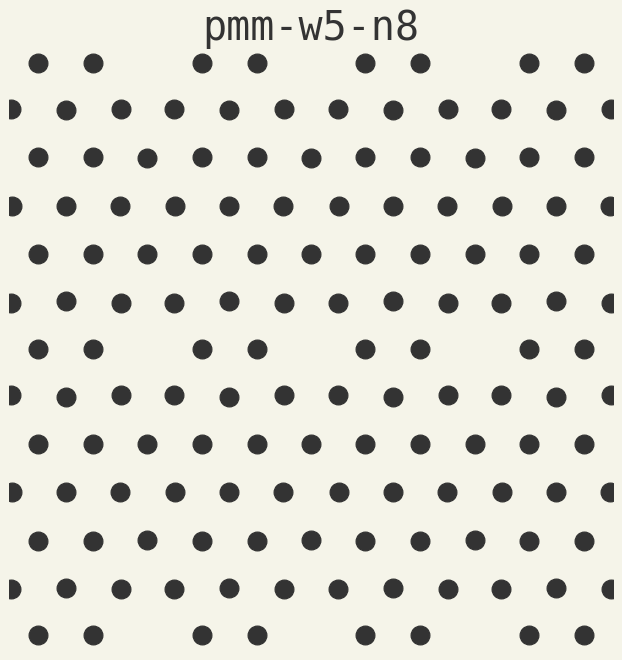

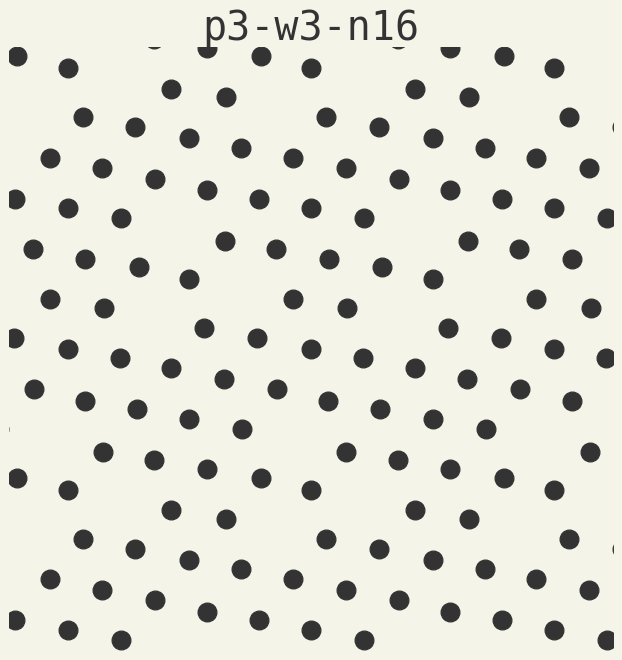

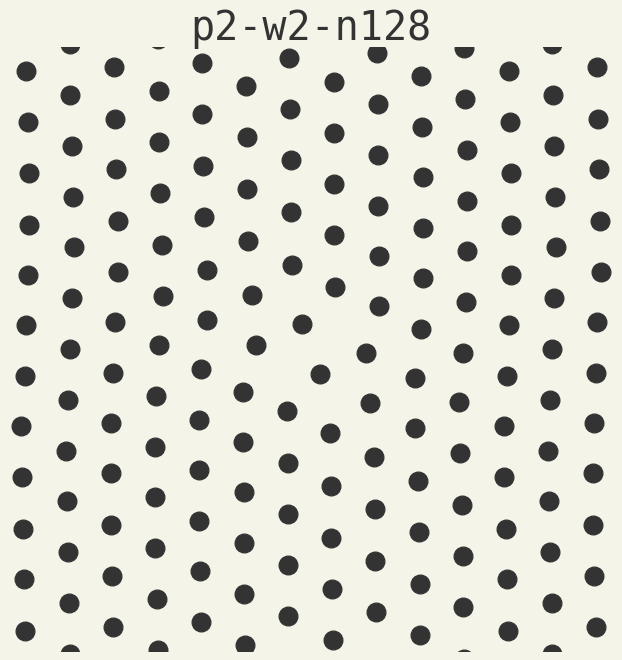

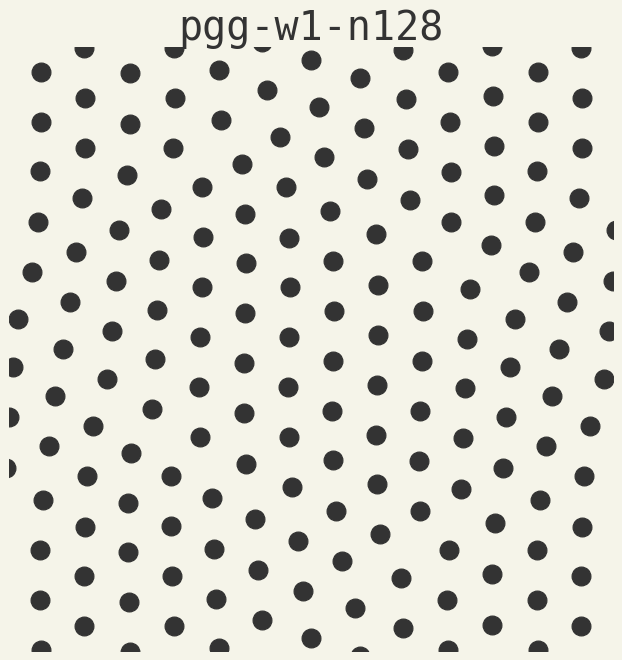

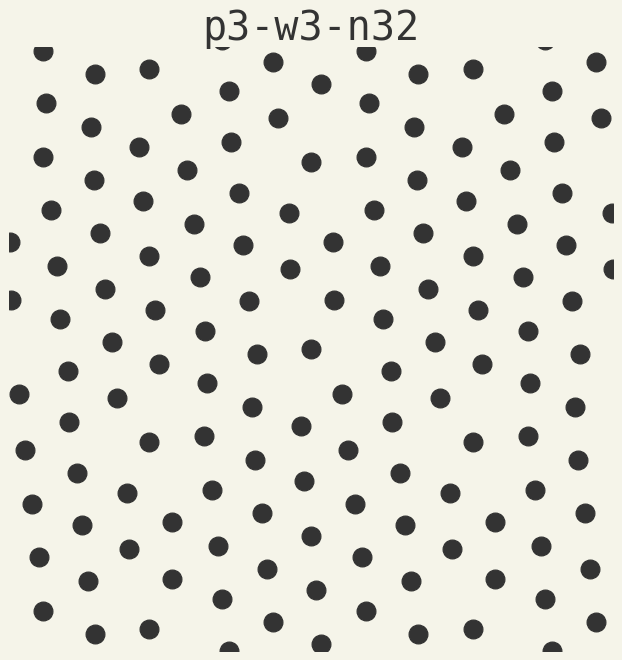

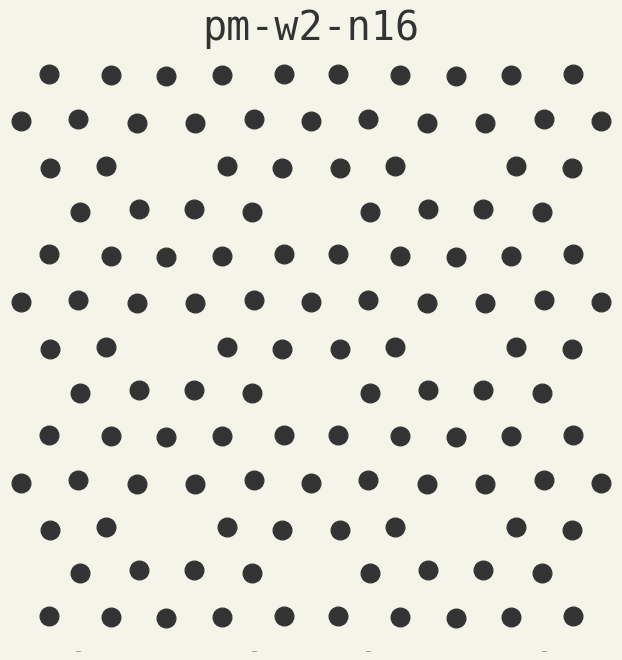

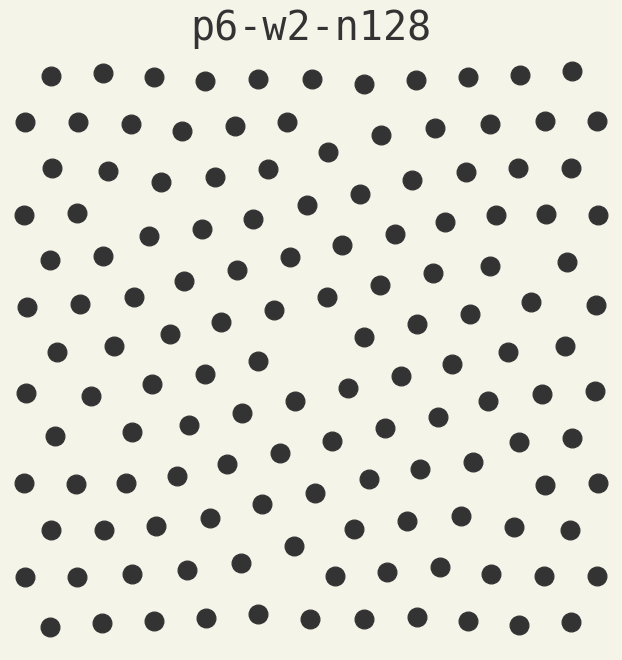

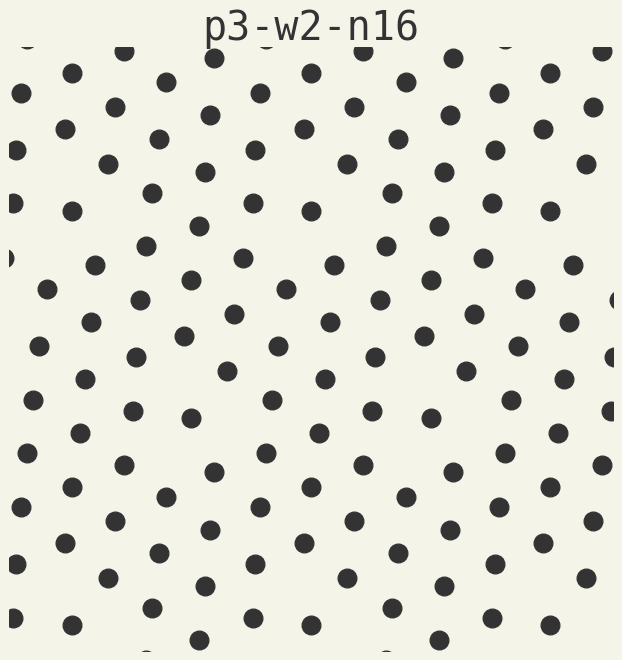

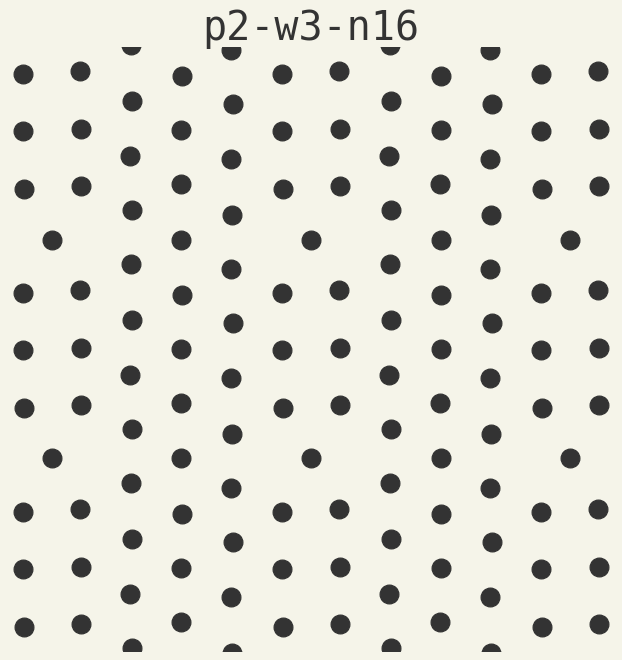

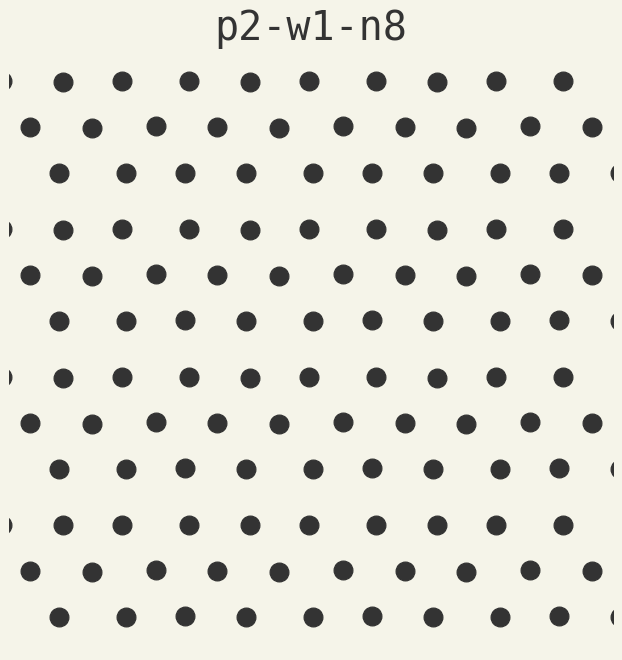

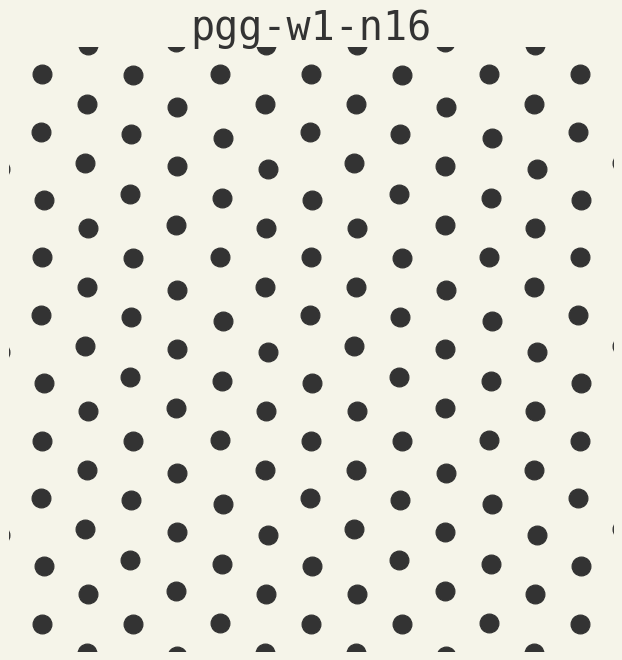

In [34]:
k = 25
top = cdf[cdf.Time == cdf.Time.max()].sort_values(by=['RMSD']).Traj.values[k:2*k]

clips = []
for t in top:
    c = plot_traj(trajs[t][:60 * 3], title=t)
    clips.append(c)
write_video(clips, 'top.mp4')

                                                                                                                                                                                                                                                                                        
t:   2%|███▊                                                                                                                                                                                                                              | 69/4125 [1:04:07<01:58, 34.34it/s, now=None]
                                                                                                                                                                                                                                                                                        
t:   1%|███▏                                                                                                                                                 

Moviepy - Building video sample.mp4.
Moviepy - Writing video sample.mp4





t:   0%|                                                                                                                                                                                                                                             | 0/7140 [00:00<?, ?it/s, now=None]

t:   0%|▏                                                                                                                                                                                                                                    | 4/7140 [00:00<03:20, 35.63it/s, now=None]

t:   0%|▎                                                                                                                                                                                                                                    | 8/7140 [00:00<03:25, 34.74it/s, now=None]

t:   0%|▍                                                                                                                                               

t:   3%|███████                                                                                                                                                                                                                            | 224/7140 [00:06<03:17, 34.93it/s, now=None]

t:   3%|███████▏                                                                                                                                                                                                                           | 228/7140 [00:06<03:18, 34.89it/s, now=None]

t:   3%|███████▍                                                                                                                                                                                                                           | 232/7140 [00:06<03:17, 34.94it/s, now=None]

t:   3%|███████▌                                                                                                                                          

t:   6%|████████████▍                                                                                                                                                                                                                      | 393/7140 [00:14<05:05, 22.06it/s, now=None]

t:   6%|████████████▌                                                                                                                                                                                                                      | 396/7140 [00:14<05:05, 22.05it/s, now=None]

t:   6%|████████████▋                                                                                                                                                                                                                      | 399/7140 [00:14<05:06, 21.97it/s, now=None]

t:   6%|████████████▊                                                                                                                                     

t:   8%|█████████████████▊                                                                                                                                                                                                                 | 561/7140 [00:22<05:01, 21.79it/s, now=None]

t:   8%|█████████████████▉                                                                                                                                                                                                                 | 564/7140 [00:22<05:04, 21.62it/s, now=None]

t:   8%|██████████████████                                                                                                                                                                                                                 | 567/7140 [00:22<05:03, 21.65it/s, now=None]

t:   8%|██████████████████                                                                                                                                

t:  10%|███████████████████████▏                                                                                                                                                                                                           | 729/7140 [00:29<04:54, 21.78it/s, now=None]

t:  10%|███████████████████████▎                                                                                                                                                                                                           | 732/7140 [00:29<05:43, 18.68it/s, now=None]

t:  10%|███████████████████████▎                                                                                                                                                                                                           | 734/7140 [00:30<06:24, 16.66it/s, now=None]

t:  10%|███████████████████████▍                                                                                                                          

t:  12%|████████████████████████████▏                                                                                                                                                                                                      | 887/7140 [00:37<05:05, 20.49it/s, now=None]

t:  12%|████████████████████████████▎                                                                                                                                                                                                      | 890/7140 [00:37<04:59, 20.84it/s, now=None]

t:  13%|████████████████████████████▍                                                                                                                                                                                                      | 893/7140 [00:38<04:57, 20.98it/s, now=None]

t:  13%|████████████████████████████▍                                                                                                                     

t:  15%|█████████████████████████████████▍                                                                                                                                                                                                | 1055/7140 [00:45<04:48, 21.09it/s, now=None]

t:  15%|█████████████████████████████████▍                                                                                                                                                                                                | 1058/7140 [00:45<04:44, 21.36it/s, now=None]

t:  15%|█████████████████████████████████▌                                                                                                                                                                                                | 1061/7140 [00:45<04:42, 21.53it/s, now=None]

t:  15%|█████████████████████████████████▋                                                                                                                

t:  17%|██████████████████████████████████████▌                                                                                                                                                                                           | 1217/7140 [00:53<04:32, 21.74it/s, now=None]

t:  17%|██████████████████████████████████████▌                                                                                                                                                                                           | 1220/7140 [00:53<04:32, 21.73it/s, now=None]

t:  17%|██████████████████████████████████████▋                                                                                                                                                                                           | 1223/7140 [00:53<04:33, 21.60it/s, now=None]

t:  17%|██████████████████████████████████████▊                                                                                                           

t:  19%|███████████████████████████████████████████▌                                                                                                                                                                                      | 1378/7140 [01:01<06:10, 15.54it/s, now=None]

t:  19%|███████████████████████████████████████████▋                                                                                                                                                                                      | 1381/7140 [01:01<05:32, 17.33it/s, now=None]

t:  19%|███████████████████████████████████████████▊                                                                                                                                                                                      | 1384/7140 [01:01<05:10, 18.54it/s, now=None]

t:  19%|███████████████████████████████████████████▉                                                                                                      

t:  22%|████████████████████████████████████████████████▉                                                                                                                                                                                 | 1546/7140 [01:09<04:31, 20.58it/s, now=None]

t:  22%|█████████████████████████████████████████████████                                                                                                                                                                                 | 1549/7140 [01:09<04:31, 20.61it/s, now=None]

t:  22%|█████████████████████████████████████████████████                                                                                                                                                                                 | 1552/7140 [01:09<04:26, 20.93it/s, now=None]

t:  22%|█████████████████████████████████████████████████▏                                                                                                

t:  24%|██████████████████████████████████████████████████████                                                                                                                                                                            | 1708/7140 [01:17<04:10, 21.66it/s, now=None]

t:  24%|██████████████████████████████████████████████████████▏                                                                                                                                                                           | 1711/7140 [01:17<04:13, 21.37it/s, now=None]

t:  24%|██████████████████████████████████████████████████████▎                                                                                                                                                                           | 1714/7140 [01:17<04:14, 21.32it/s, now=None]

t:  24%|██████████████████████████████████████████████████████▎                                                                                           

t:  26%|██████████████████████████████████████████████████████████▉                                                                                                                                                                       | 1861/7140 [01:25<06:22, 13.80it/s, now=None]

t:  26%|██████████████████████████████████████████████████████████▉                                                                                                                                                                       | 1863/7140 [01:25<05:47, 15.17it/s, now=None]

t:  26%|███████████████████████████████████████████████████████████                                                                                                                                                                       | 1866/7140 [01:25<05:12, 16.88it/s, now=None]

t:  26%|███████████████████████████████████████████████████████████▏                                                                                      

t:  28%|███████████████████████████████████████████████████████████████▊                                                                                                                                                                  | 2017/7140 [01:33<05:03, 16.87it/s, now=None]

t:  28%|███████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 2020/7140 [01:33<04:42, 18.11it/s, now=None]

t:  28%|████████████████████████████████████████████████████████████████                                                                                                                                                                  | 2022/7140 [01:33<04:39, 18.30it/s, now=None]

t:  28%|████████████████████████████████████████████████████████████████                                                                                  

t:  30%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 2176/7140 [01:41<03:57, 20.92it/s, now=None]

t:  31%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 2179/7140 [01:41<03:57, 20.92it/s, now=None]

t:  31%|█████████████████████████████████████████████████████████████████████                                                                                                                                                             | 2182/7140 [01:41<03:55, 21.02it/s, now=None]

t:  31%|█████████████████████████████████████████████████████████████████████▏                                                                            

t:  33%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                                                       | 2344/7140 [01:49<03:39, 21.86it/s, now=None]

t:  33%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 2347/7140 [01:49<03:41, 21.65it/s, now=None]

t:  33%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 2350/7140 [01:49<03:39, 21.79it/s, now=None]

t:  33%|██████████████████████████████████████████████████████████████████████████▍                                                                       

t:  35%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 2505/7140 [01:57<03:52, 19.93it/s, now=None]

t:  35%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                  | 2508/7140 [01:57<03:50, 20.13it/s, now=None]

t:  35%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                  | 2511/7140 [01:57<03:48, 20.25it/s, now=None]

t:  35%|███████████████████████████████████████████████████████████████████████████████▌                                                                  

t:  37%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                             | 2673/7140 [02:05<03:30, 21.18it/s, now=None]

t:  37%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 2676/7140 [02:05<03:32, 21.01it/s, now=None]

t:  38%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                             | 2679/7140 [02:05<03:34, 20.79it/s, now=None]

t:  38%|████████████████████████████████████████████████████████████████████████████████████▉                                                             

t:  40%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 2841/7140 [02:13<03:20, 21.43it/s, now=None]

t:  40%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 2844/7140 [02:13<03:18, 21.62it/s, now=None]

t:  40%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 2847/7140 [02:13<03:23, 21.08it/s, now=None]

t:  40%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                       

t:  42%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 3003/7140 [02:21<03:09, 21.78it/s, now=None]

t:  42%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 3006/7140 [02:21<03:11, 21.59it/s, now=None]

t:  42%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 3009/7140 [02:22<03:13, 21.36it/s, now=None]

t:  42%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                  

t:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 3171/7140 [02:29<03:01, 21.82it/s, now=None]

t:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 3174/7140 [02:29<03:04, 21.49it/s, now=None]

t:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 3177/7140 [02:29<03:02, 21.70it/s, now=None]

t:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             

t:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 3339/7140 [02:37<02:53, 21.94it/s, now=None]

t:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 3342/7140 [02:37<03:07, 20.27it/s, now=None]

t:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 3345/7140 [02:37<03:45, 16.82it/s, now=None]

t:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        

t:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 3501/7140 [02:45<02:46, 21.90it/s, now=None]

t:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 3504/7140 [02:45<02:49, 21.42it/s, now=None]

t:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 3507/7140 [02:45<02:52, 21.04it/s, now=None]

t:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   

t:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 3669/7140 [02:53<02:40, 21.69it/s, now=None]

t:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 3672/7140 [02:53<02:39, 21.72it/s, now=None]

t:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 3675/7140 [02:53<02:42, 21.35it/s, now=None]

t:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             

t:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 3830/7140 [03:01<02:55, 18.88it/s, now=None]

t:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 3833/7140 [03:01<02:46, 19.85it/s, now=None]

t:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 3836/7140 [03:01<02:41, 20.46it/s, now=None]

t:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        

t:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 3998/7140 [03:09<02:28, 21.13it/s, now=None]

t:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 4001/7140 [03:09<02:28, 21.18it/s, now=None]

t:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 4004/7140 [03:09<02:29, 21.00it/s, now=None]

t:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   

t:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 4158/7140 [03:16<02:20, 21.24it/s, now=None]

t:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 4161/7140 [03:17<02:20, 21.26it/s, now=None]

t:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 4164/7140 [03:17<02:19, 21.39it/s, now=None]

t:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              

t:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 4316/7140 [03:25<02:22, 19.77it/s, now=None]

t:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 4318/7140 [03:25<02:22, 19.80it/s, now=None]

t:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 4320/7140 [03:25<02:22, 19.84it/s, now=None]

t:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         

t:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 4453/7140 [03:32<02:08, 20.83it/s, now=None]

t:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 4456/7140 [03:32<02:07, 21.05it/s, now=None]

t:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 4459/7140 [03:32<02:06, 21.21it/s, now=None]

t:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    

t:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 4608/7140 [03:40<02:08, 19.74it/s, now=None]

t:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 4610/7140 [03:40<02:08, 19.76it/s, now=None]

t:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 4612/7140 [03:40<02:07, 19.81it/s, now=None]

t:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

t:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 4742/7140 [03:47<01:55, 20.76it/s, now=None]

t:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 4745/7140 [03:47<01:54, 21.00it/s, now=None]

t:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 4748/7140 [03:47<01:56, 20.46it/s, now=None]

t:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

t:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 4909/7140 [03:55<01:49, 20.40it/s, now=None]

t:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 4912/7140 [03:55<01:49, 20.26it/s, now=None]

t:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 4915/7140 [03:55<01:49, 20.35it/s, now=None]

t:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

t:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 5070/7140 [04:03<01:40, 20.64it/s, now=None]

t:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 5073/7140 [04:03<01:38, 21.02it/s, now=None]

t:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 5076/7140 [04:03<01:37, 21.26it/s, now=None]

t:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

t:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 5236/7140 [04:11<01:34, 20.24it/s, now=None]

t:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 5239/7140 [04:11<01:32, 20.56it/s, now=None]

t:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 5242/7140 [04:11<01:32, 20.48it/s, now=None]

t:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

t:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 5397/7140 [04:19<01:23, 20.80it/s, now=None]

t:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 5400/7140 [04:19<01:23, 20.75it/s, now=None]

t:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 5403/7140 [04:19<01:22, 20.93it/s, now=None]

t:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

t:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 5565/7140 [04:27<01:13, 21.43it/s, now=None]

t:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 5568/7140 [04:27<01:12, 21.55it/s, now=None]

t:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 5571/7140 [04:27<01:12, 21.56it/s, now=None]

t:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

t:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 5733/7140 [04:35<01:05, 21.57it/s, now=None]

t:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 5736/7140 [04:35<01:05, 21.56it/s, now=None]

t:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 5739/7140 [04:35<01:06, 21.13it/s, now=None]

t:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

t:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 5878/7140 [04:43<01:03, 20.02it/s, now=None]

t:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 5881/7140 [04:43<01:02, 20.20it/s, now=None]

t:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 5884/7140 [04:43<01:02, 20.17it/s, now=None]

t:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

t:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 6040/7140 [04:51<00:53, 20.44it/s, now=None]

t:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 6043/7140 [04:51<00:53, 20.70it/s, now=None]

t:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 6046/7140 [04:51<00:52, 20.76it/s, now=None]

t:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

t:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 6200/7140 [04:59<00:45, 20.79it/s, now=None]

t:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 6203/7140 [04:59<00:44, 20.99it/s, now=None]

t:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 6206/7140 [04:59<00:44, 21.00it/s, now=None]

t:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

t:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 6363/7140 [05:07<00:37, 20.84it/s, now=None]

t:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 6366/7140 [05:07<00:37, 20.77it/s, now=None]

t:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 6369/7140 [05:07<00:36, 20.92it/s, now=None]

t:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

t:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 6525/7140 [05:15<00:29, 20.74it/s, now=None]

t:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 6528/7140 [05:15<00:29, 20.94it/s, now=None]

t:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 6531/7140 [05:16<00:29, 20.62it/s, now=None]

t:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

t:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 6670/7140 [05:23<00:39, 11.91it/s, now=None]

t:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 6672/7140 [05:23<00:36, 12.69it/s, now=None]

t:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 6675/7140 [05:23<00:31, 14.88it/s, now=None]

t:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

t:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 6828/7140 [05:31<00:14, 20.99it/s, now=None]

t:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 6831/7140 [05:31<00:14, 21.01it/s, now=None]

t:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 6834/7140 [05:31<00:14, 20.96it/s, now=None]

t:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

t:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 6996/7140 [05:39<00:06, 21.33it/s, now=None]

t:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 6999/7140 [05:39<00:06, 21.39it/s, now=None]

t:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 7002/7140 [05:39<00:06, 21.33it/s, now=None]

t:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Moviepy - Done !
Moviepy - video ready sample.mp4


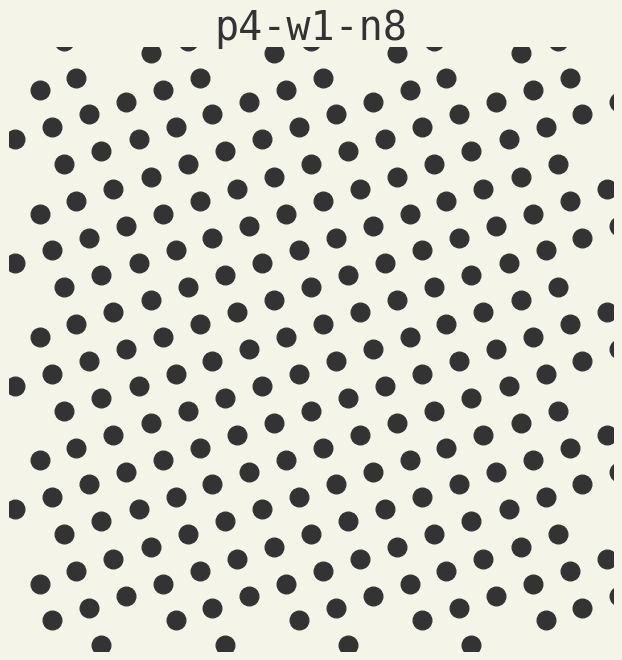

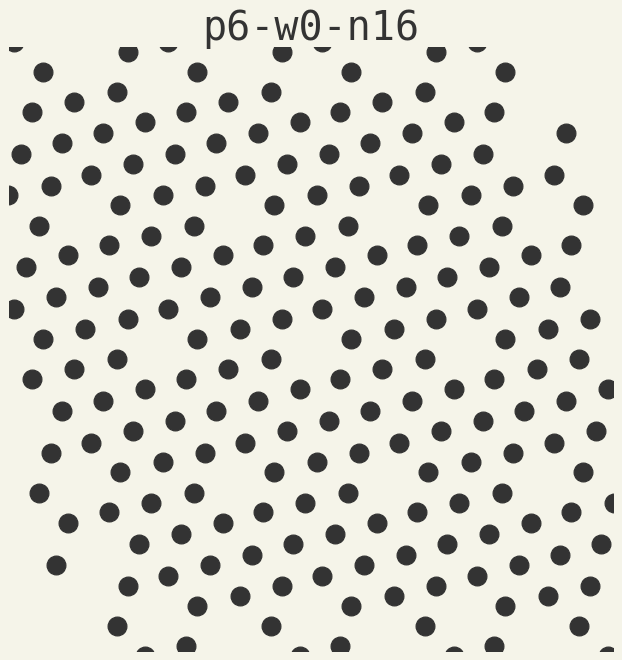

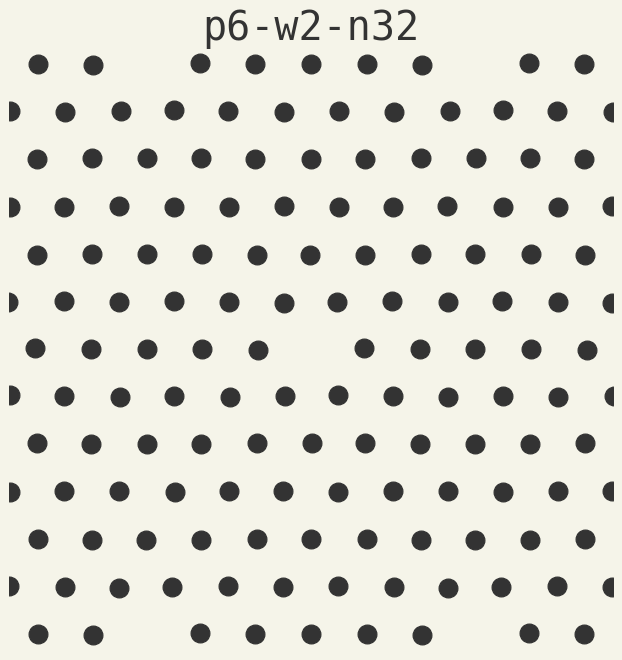

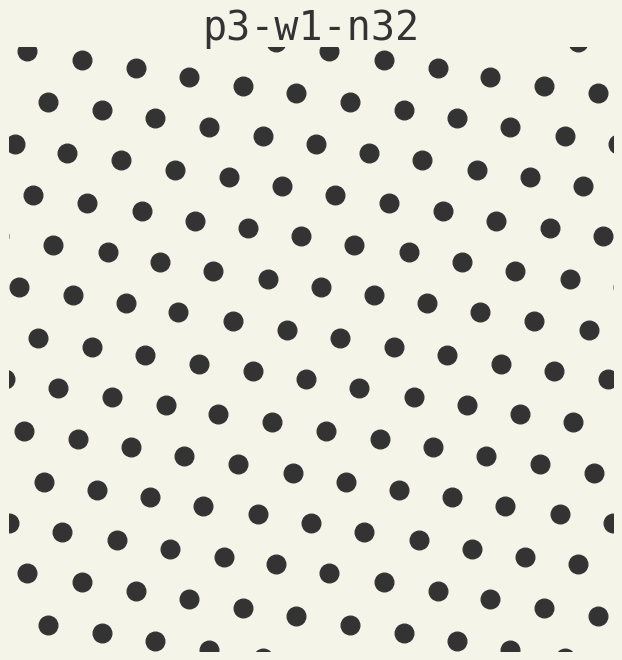

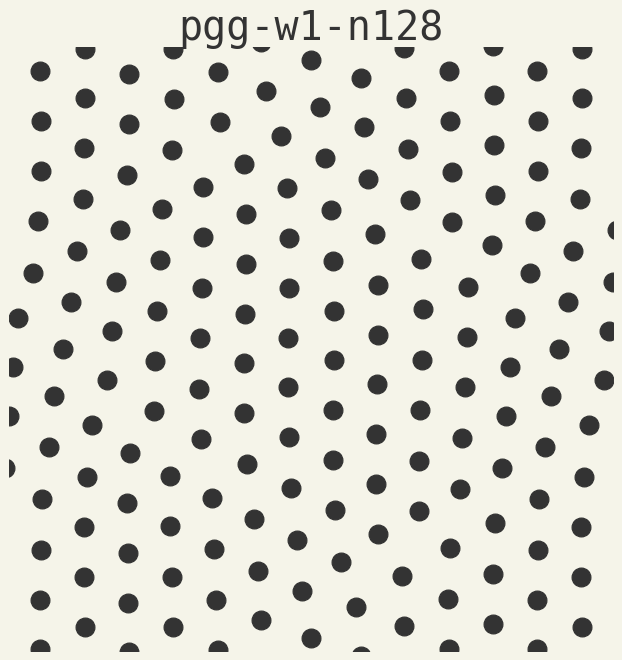

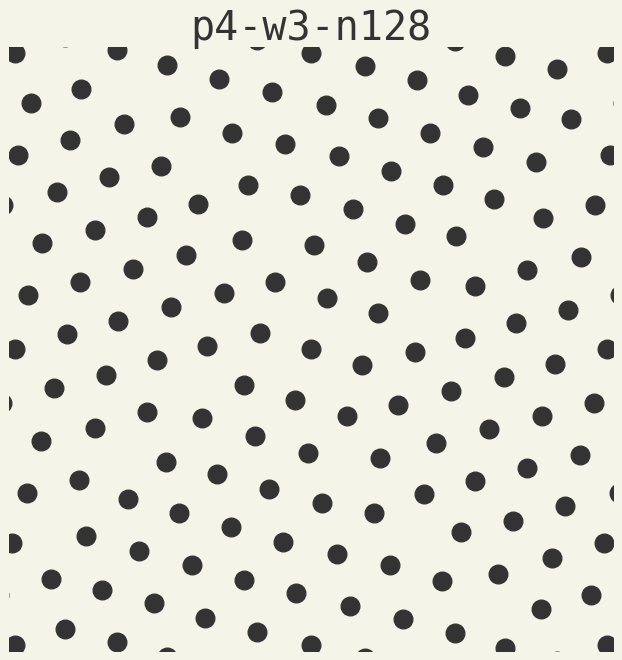

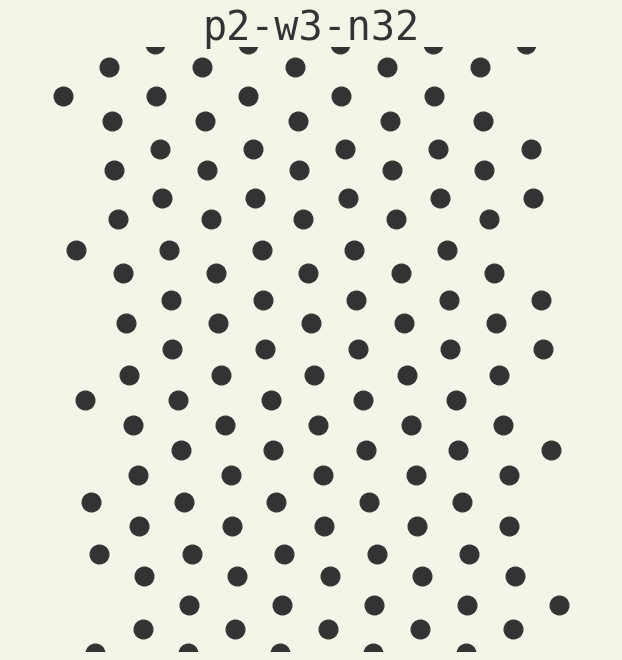

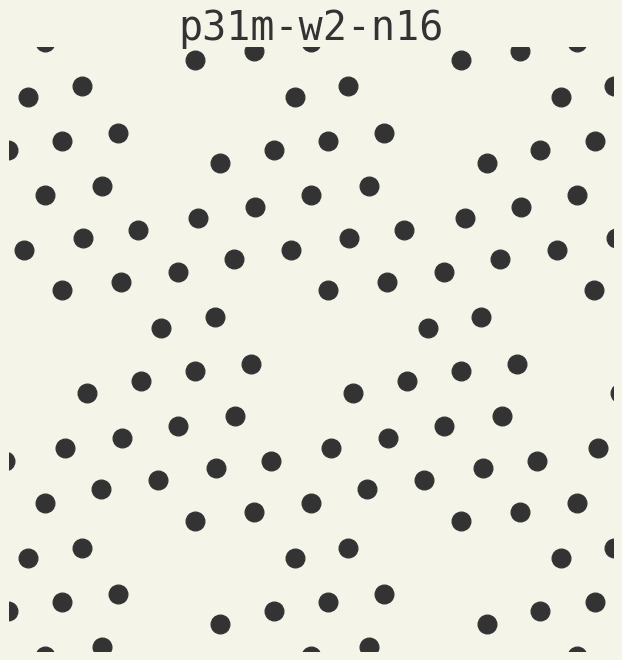

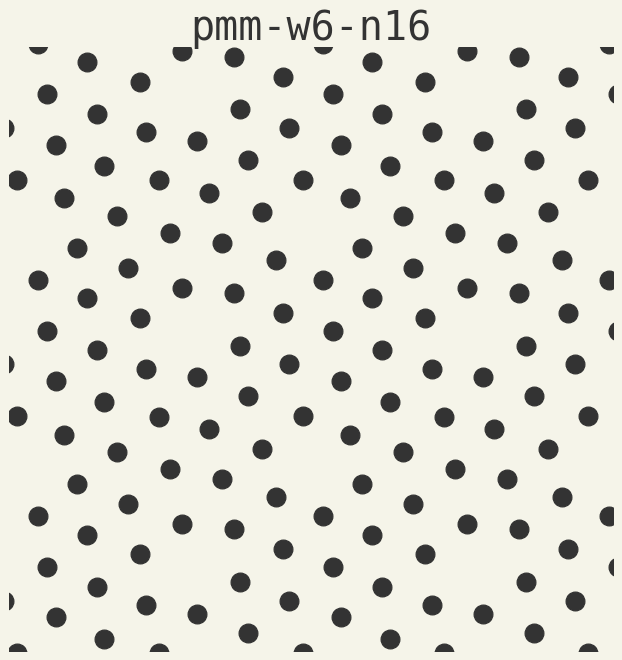

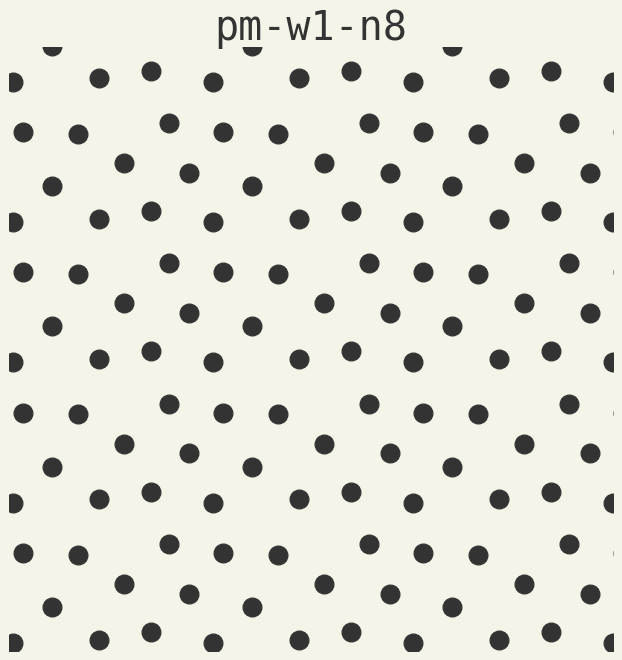

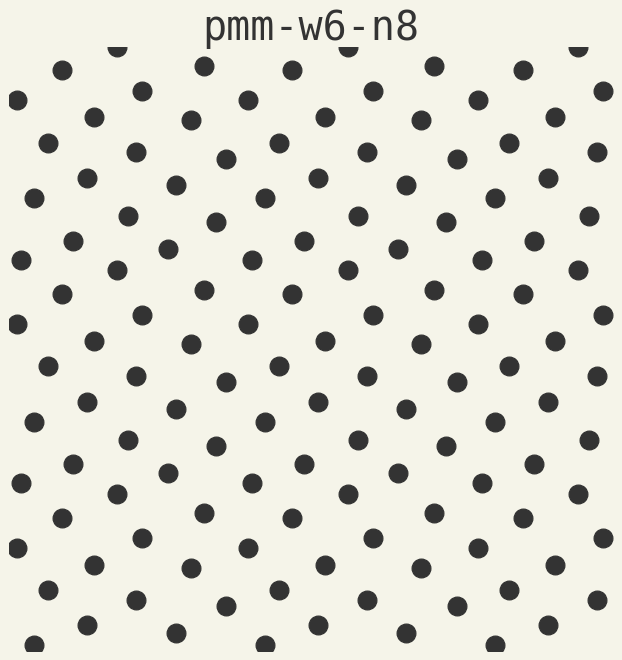

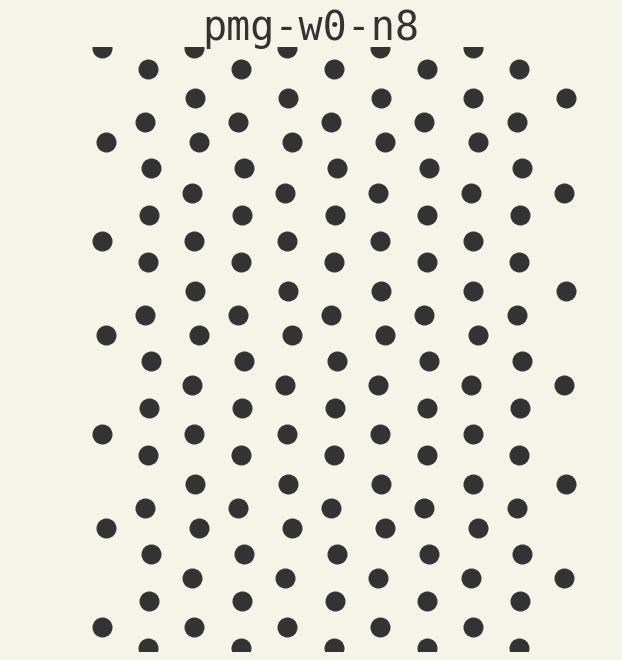

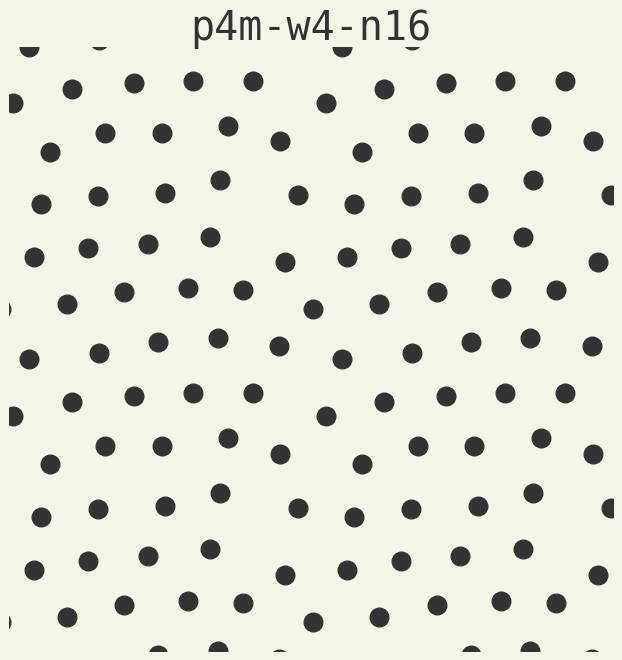

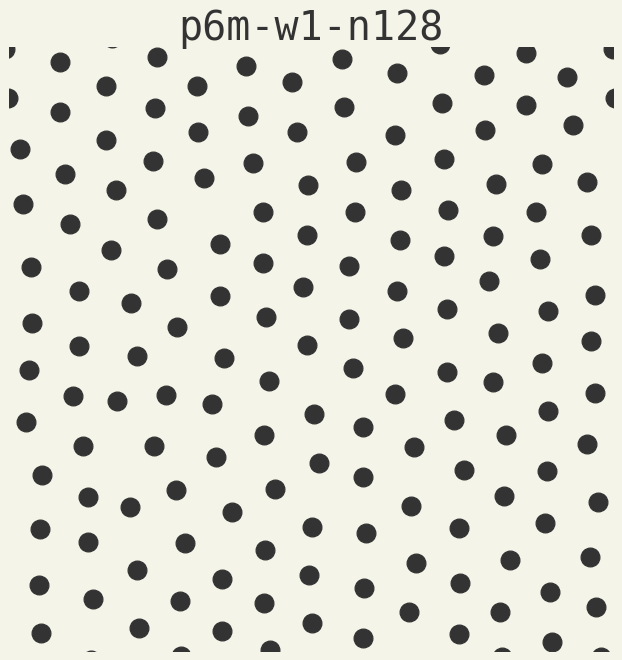

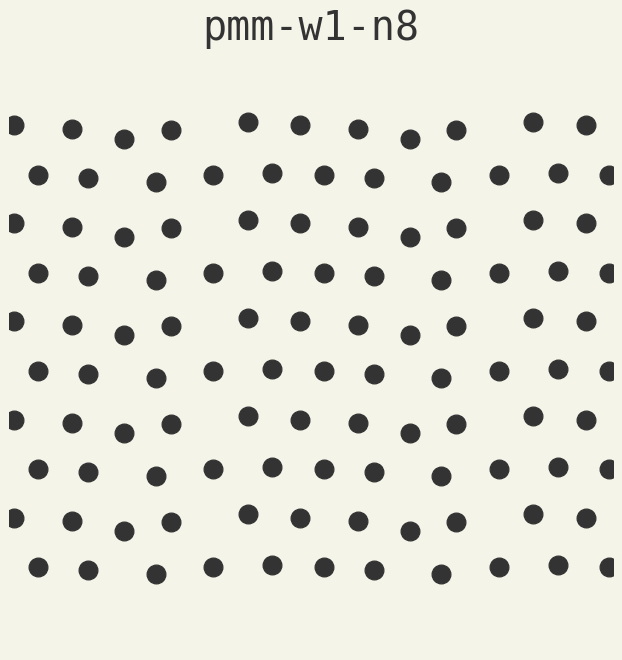

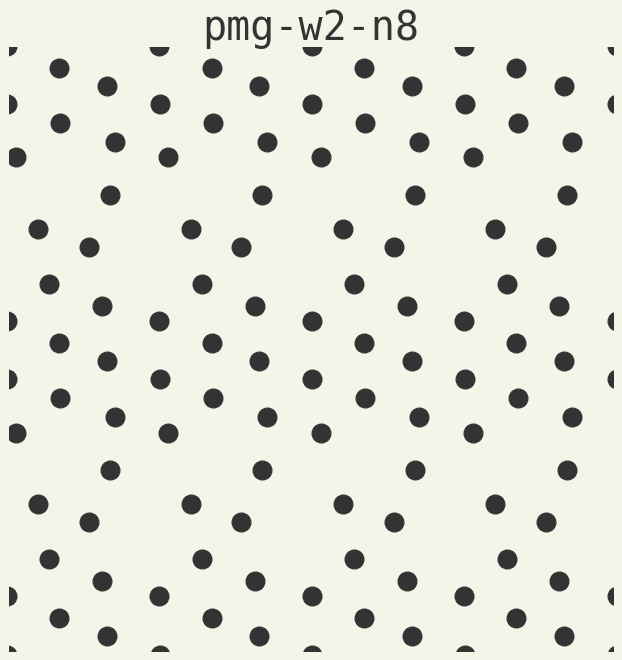

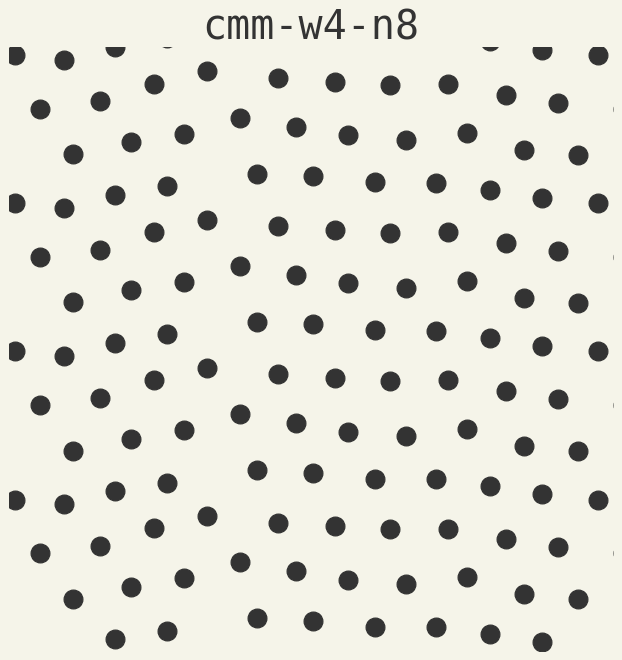

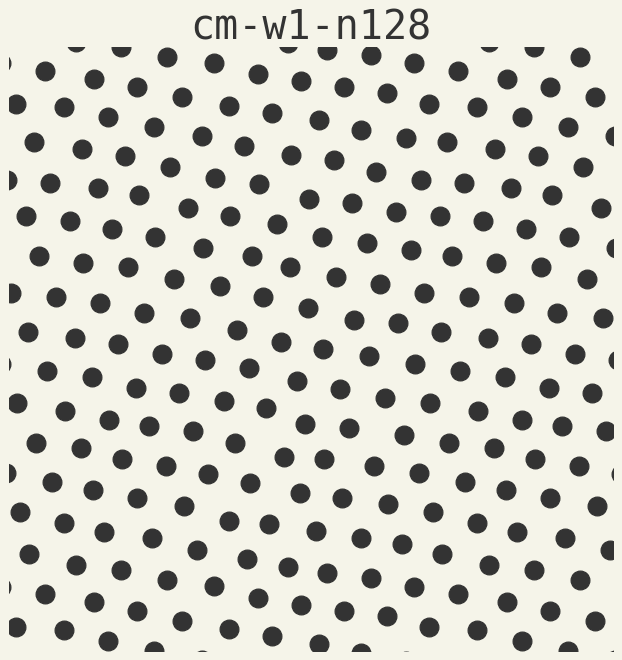

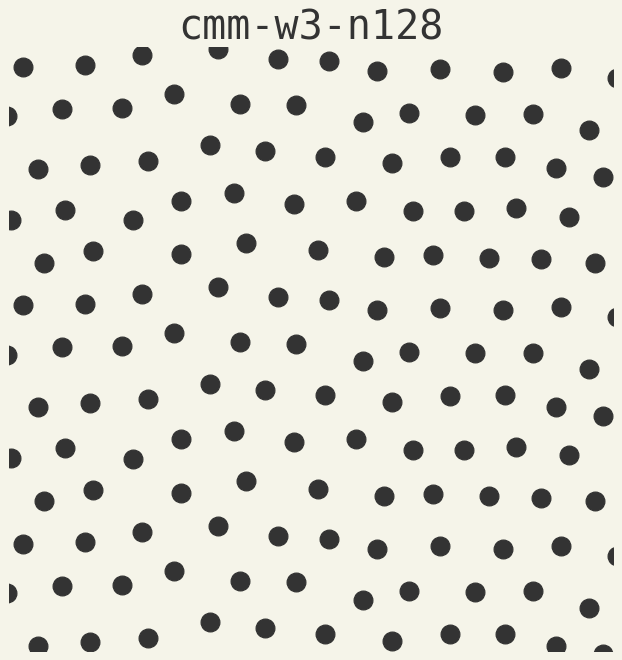

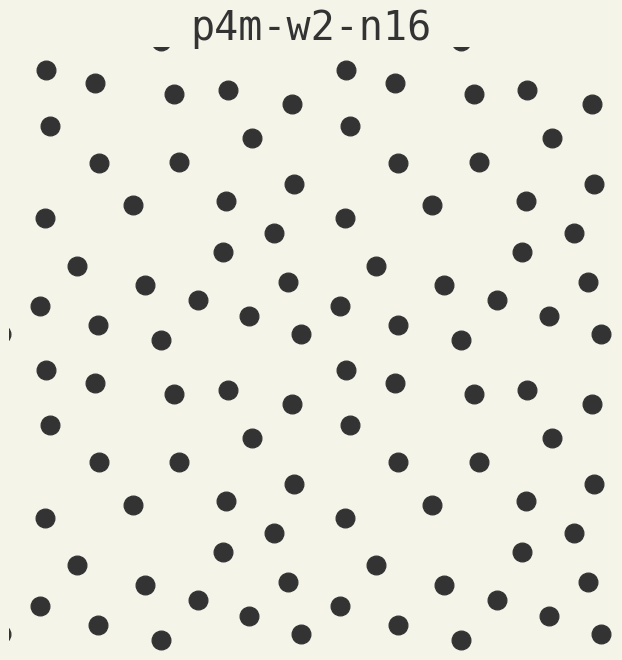

In [37]:
k = 25
bottom = cdf[cdf.Time == cdf.Time.max()].sort_values(by=['RMSD']).Traj.values[10::8]

clips = []
for t in bottom:
    # find when break-up happens
    r = cdf[cdf.Traj == t].RMSD.values
    mint = 60
    delta = r[mint+1:] - r[mint:-1]
    i = np.argmax(delta) + 180
    c = plot_traj(trajs[t][:i+mint], title=t)
    clips.append(c)
write_video(clips, 'sample.mp4')